In [ ]:
import numpy as np
from numpy.fft import fftshift
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.signal import butter, filtfilt, resample_poly, freqz, hilbert

# Load stereo audio file
path_to_file = r'C:\Users\jlefk\vscdoe\stereo.wav'
fs_audio, audio = wavfile.read(path_to_file)


# Extract Left and Right audio channels
audio_L = audio[:, 0]
audio_R = audio[:, 1]

# Time vector for original audio
t_audio = np.arange(len(audio_L)) / fs_audio

In [2]:
# Anti-Aliasing Low-Pass Filter (LPF) @ fs_audio (0-15 kHz)
Nfilt = 5
cutoff = 15e3
b_AAF, a_AAF = butter(Nfilt, Wn=cutoff, btype='low', fs=fs_audio)

'''
fs=fs_audio
# RF Low-Pass Filter (LPF) @ fs (0-53 kHz)
Nfilt = 11
cutoff = 53e3
b_LPF_rf, a_LPF_rf = butter(Nfilt, Wn=cutoff, btype='low', fs=fs)

# Audio LPF @ fs (0-15 kHz)
Nfilt = 9
cutoff = 15e3
b_LPF_audio, a_LPF_audio = butter(Nfilt, Wn=cutoff, btype='low', fs=fs)

# Band-Pass Filter (BPF) @ fs (23-53 kHz)
Nfilt_band = 7
cutoff_band = [23e3, 53e3]
b_BPF, a_BPF = butter(Nfilt_band, Wn=cutoff_band, btype='band', fs=fs)

# Narrowband filter @ fs (19 kHz)
Nfilt_band = 5
cutoff_band = [18e3, 20e3]
b_narrow, a_narrow = butter(Nfilt_band, Wn=cutoff_band, btype='band', fs=fs)
'''

"\nfs=fs_audio\n# RF Low-Pass Filter (LPF) @ fs (0-53 kHz)\nNfilt = 11\ncutoff = 53e3\nb_LPF_rf, a_LPF_rf = butter(Nfilt, Wn=cutoff, btype='low', fs=fs)\n\n# Audio LPF @ fs (0-15 kHz)\nNfilt = 9\ncutoff = 15e3\nb_LPF_audio, a_LPF_audio = butter(Nfilt, Wn=cutoff, btype='low', fs=fs)\n\n# Band-Pass Filter (BPF) @ fs (23-53 kHz)\nNfilt_band = 7\ncutoff_band = [23e3, 53e3]\nb_BPF, a_BPF = butter(Nfilt_band, Wn=cutoff_band, btype='band', fs=fs)\n\n# Narrowband filter @ fs (19 kHz)\nNfilt_band = 5\ncutoff_band = [18e3, 20e3]\nb_narrow, a_narrow = butter(Nfilt_band, Wn=cutoff_band, btype='band', fs=fs)\n"

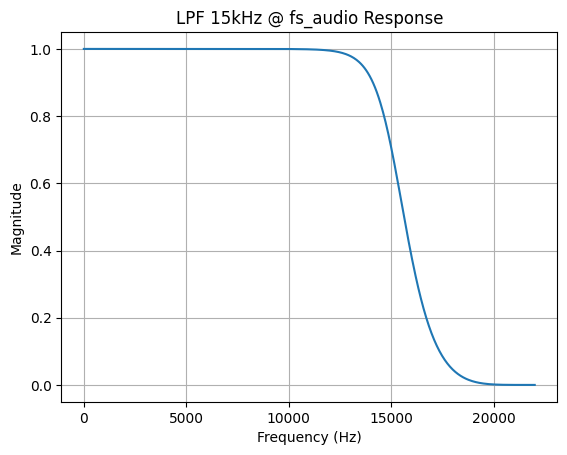

In [3]:
plt.figure()
w, h = freqz(b_AAF, a_AAF, fs=fs_audio)
plt.plot(w, abs(h))
plt.title('LPF 15kHz @ fs_audio Response')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.grid()
plt.show()

In [4]:
# Apply LPF to L and R audio signals
audio_L_filt = filtfilt(b_AAF, a_AAF, audio_L)
audio_R_filt = filtfilt(b_AAF, a_AAF, audio_R)

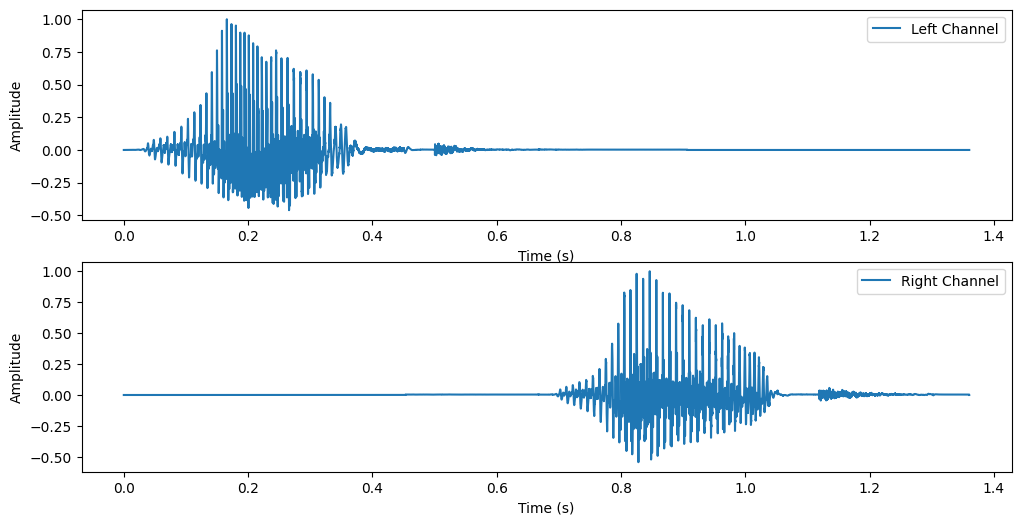

In [5]:

plt.figure(figsize=(12,6))
plt.subplot(2,1,1)
plt.plot(t_audio, audio_L_filt, label='Left Channel')
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()

plt.subplot(2,1,2)
plt.plot(t_audio, audio_R_filt, label='Right Channel')
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()


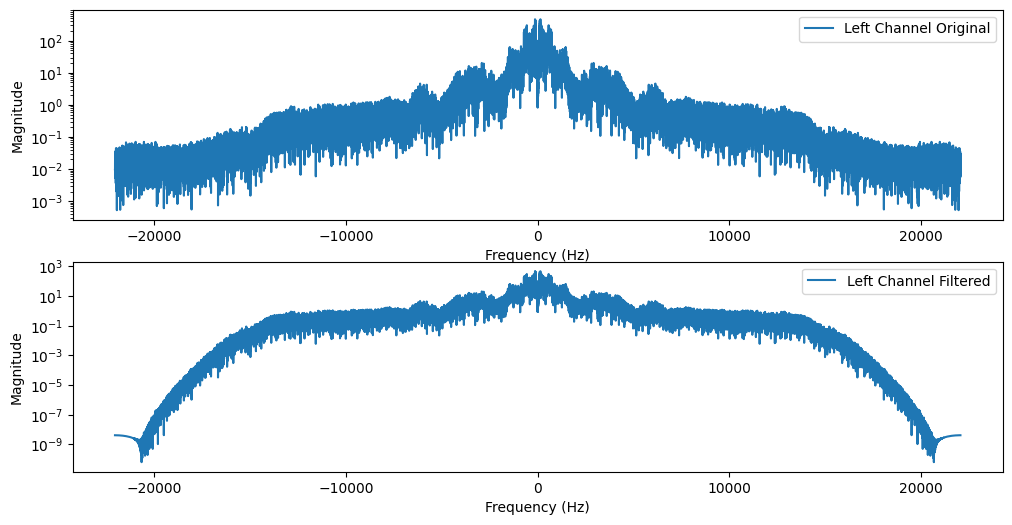

In [106]:
N = len(audio_L)
freq_audio = np.fft.fftfreq(N, d=1/fs_audio)
audio_L_fft = np.fft.fft(audio_L)  # FFT of original audio
audio_L_filt_fft = np.fft.fft(audio_L_filt)  # FFT of filtered audio


audio_L_fft = np.abs(audio_L_fft)
audio_L_filt_fft = np.abs(audio_L_filt_fft)

plt.figure(figsize=(12,6))
plt.subplot(2,1,1)
plt.semilogy(fftshift(freq_audio), fftshift(audio_L_fft), label='Left Channel Original')
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.legend()

plt.subplot(2,1,2)
plt.semilogy(fftshift(freq_audio), fftshift(audio_L_filt_fft), label='Left Channel Filtered')
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.legend()


In [7]:
M = 15
fs = M * fs_audio  # 661.5 kHz

# Upsample the audio
mL = resample_poly(audio_L_filt, M, 1)
mR = resample_poly(audio_R_filt, M, 1)

# Time vector for resampled audio
N = len(mL)
t = np.arange(N) / fs

In [8]:
# Pilot Signal
fp = 19e3  # Pilot frequency
ap = 0.1   # Pilot amplitude
pilot = ap * np.cos(2 * np.pi * fp * t)

# DSB-SC Modulated (L-R) Signal
DSB_carrier = np.cos(2 * np.pi * 2 * fp * t)
mLmR_dsb = (mL - mR) * DSB_carrier

# Composite Message Signal m(t)
mTx = mL + mR +pilot + mLmR_dsb

# Normalize message signal
mTx /= np.max(np.abs(mTx))

In [9]:
mTx_fft= np.fft.fft(mTx)
mTx_fft = np.abs(mTx_fft)
mTx_freq = np.fft.fftfreq(N, d=1/fs)

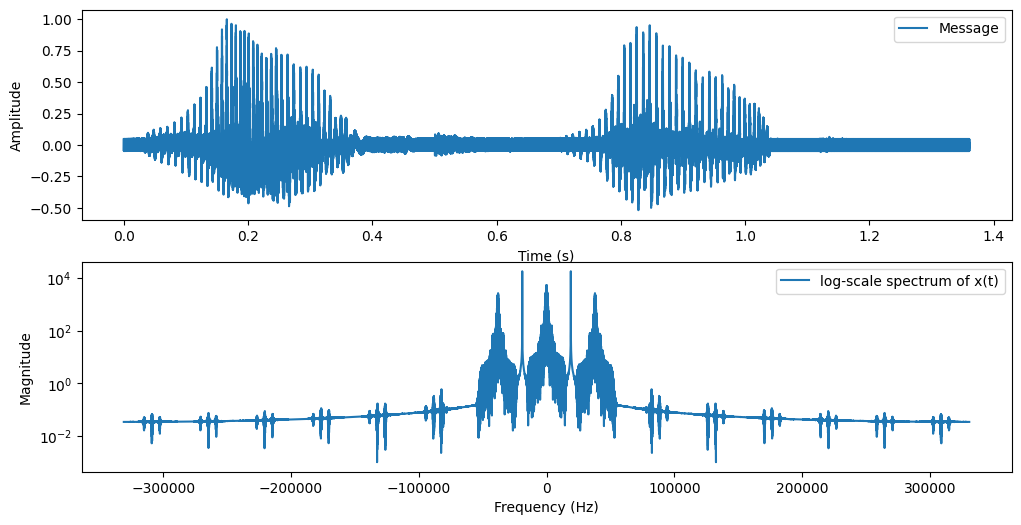

In [107]:

plt.figure(figsize=(12,6))
plt.subplot(2,1,1)
plt.plot(t, mTx, label='Message')
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()

plt.subplot(2,1,2)
plt.semilogy(fftshift(mTx_freq), fftshift(mTx_fft), label='log-scale spectrum of x(t)')
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.legend()


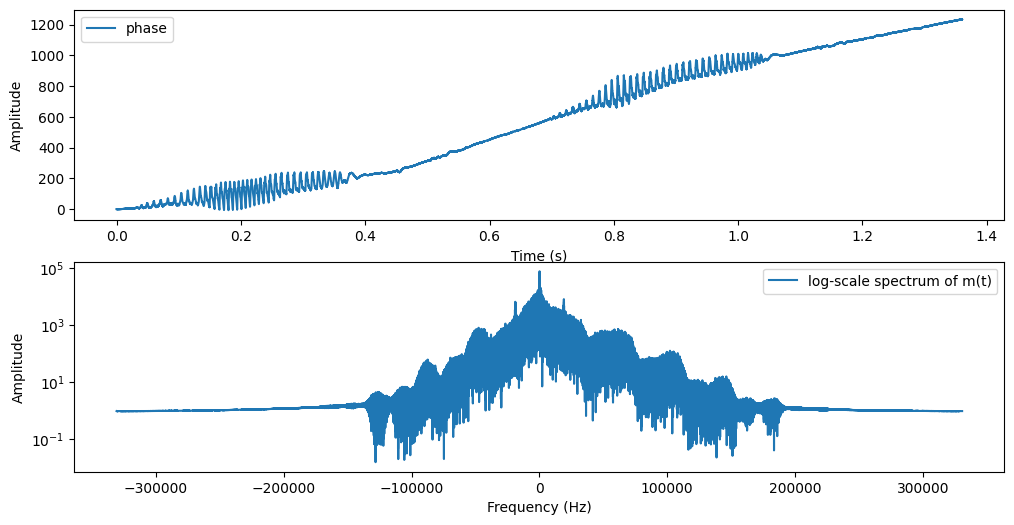

In [ ]:
dt= 1/fs
kf = 75e3
phase = 2 * np.pi*kf * np.cumsum(mTx) * dt
x = np.exp( 1j * phase)


plt.figure(figsize=(12,6))
plt.subplot(2,1,1)
plt.plot(t, phase, label='phase')
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()

plt.subplot(2,1,2)
plt.semilogy(fftshift(mTx_freq), fftshift(np.abs(np.fft.fft(x))), label='log-scale spectrum of x(t)')
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.legend()


In [67]:
import adi  # PlutoSDR library

# Set SDR parameters
sdr_carrier_freq = 100e6  # Carrier frequency (Hz)
sdr_tx_gain = -50.0  # Tx gain (-90 to 0 dB)
sdr_rx_gain = 50.0   # Rx gain (0 to 74.5 dB) - Adjust to avoid ADC saturation

# Create PlutoSDR object
sdr = adi.Pluto("ip:192.168.2.1")

# Configure common settings
sdr.sample_rate = int(fs)
sdr.gain_control_mode_chan0 = 'manual'

# Configure Tx
sdr.tx_rf_bandwidth = int(fs)  # Set Tx filter cutoff to match sample rate
sdr.tx_lo = int(sdr_carrier_freq)
sdr.tx_hardwaregain_chan0 = sdr_tx_gain  # Adjust Tx power (-90 to 0 dB)

# Configure Rx
sdr.rx_lo = int(sdr_carrier_freq)
sdr.rx_rf_bandwidth = int(fs)
sdr.rx_buffer_size = int(N)  # Buffer size for Rx samples
sdr.rx_hardwaregain_chan0 = sdr_rx_gain  # Adjust Rx gain (0 to 74.5 dB)


# Echo SDR configuration
print("sample_rate (MHz):", sdr.sample_rate * 1e-6)
print("tx_lo (MHz):", sdr.tx_lo * 1e-6)
print("tx_rf_bandwidth (MHz):", sdr.tx_rf_bandwidth * 1e-6)
print("tx_hardwaregain_chan0 (dB):", sdr.tx_hardwaregain_chan0)
print("rx_lo (MHz):", sdr.rx_lo * 1e-6)
print("rx_rf_bandwidth (MHz):", sdr.rx_rf_bandwidth * 1e-6)
print("rx_buffer_size:", sdr.rx_buffer_size)
print("rx_hardwaregain_chan0 (dB):", sdr.rx_hardwaregain_chan0)

sample_rate (MHz): 0.6615
tx_lo (MHz): 100.0
tx_rf_bandwidth (MHz): 0.6615
tx_hardwaregain_chan0 (dB): -50
rx_lo (MHz): 100.0
rx_rf_bandwidth (MHz): 0.6615
rx_buffer_size: 900000
rx_hardwaregain_chan0 (dB): 50


In [68]:
x_t = x
# Scale complex baseband signal to SDR expected range
tx_samples = x_t * 2**14  

# Enable cyclic buffer and start transmission
sdr.tx_cyclic_buffer = True
sdr.tx(tx_samples)

In [69]:
# Clear buffer before capturing data
for _ in range(3):
    sdr.rx()
  
# Capture two consecutive frames of received data
frame1 = sdr.rx()
raw_data = 2**-14 * frame1  # Scale back to (-1,1) range

In [70]:

# RF Low-Pass Filter (LPF) @ fs (0-53 kHz)
Nfilt = 11
cutoff = 53e3
b_LPF_rf, a_LPF_rf = butter(Nfilt, Wn=cutoff, btype='low', fs=fs)

# Audio LPF @ fs (0-15 kHz)
Nfilt = 9
cutoff = 15e3
b_LPF_audio, a_LPF_audio = butter(Nfilt, Wn=cutoff, btype='low', fs=fs)

# Band-Pass Filter (BPF) @ fs (23-53 kHz)
Nfilt_band = 7
cutoff_band = [23e3, 53e3]
b_BPF, a_BPF = butter(Nfilt_band, Wn=cutoff_band, btype='band', fs=fs)

# Narrowband filter @ fs (19 kHz)
Nfilt_band = 5
cutoff_band = [18e3, 20e3]
b_narrow, a_narrow = butter(Nfilt_band, Wn=cutoff_band, btype='band', fs=fs)

In [71]:
# Apply 53 kHz LPF (choose appropriate filter from Part 1)
filtered_data = filtfilt(b_LPF_rf, a_LPF_rf, raw_data)

# Extract phase from the complex signal
phase = np.unwrap(np.angle(filtered_data))

# Compute the FM demodulated message signal
mRx = np.diff(phase) / (2*np.pi)

# Append a zero to match the original length
mRx = np.append(mRx, mRx[-1])

mRx_fft = np.fft.fft(mRx)
mRx_t = np.arange(len(mRx))/fs
mRx_freq = np.fft.fftfreq(len(mRx), d= 1/fs)

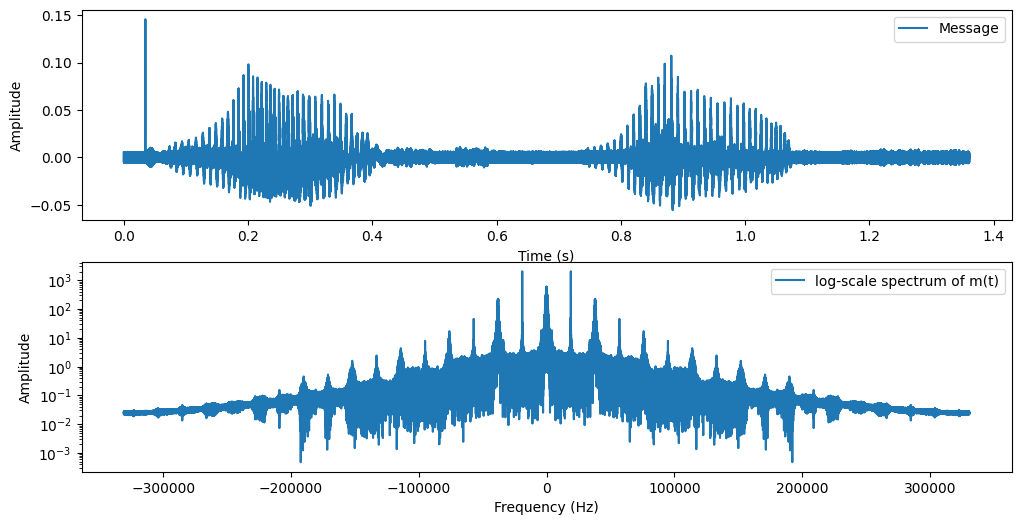

In [72]:

plt.figure(figsize=(12,6))
plt.subplot(2,1,1)
plt.plot(mRx_t, mRx, label='Message')
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()

plt.subplot(2,1,2)
plt.semilogy(fftshift(mRx_freq), fftshift(np.abs(mRx_fft)), label='log-scale spectrum of m(t)')
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.legend()


In [73]:
L_R_audio = filtfilt(b_LPF_audio, a_LPF_audio, mRx)
pilot_tone = filtfilt(b_narrow, a_narrow, mRx)
bandpass = filtfilt(b_BPF, a_BPF, mRx)

#get phase of hilbert and double
analytic = hilbert(np.real(pilot_tone))
pilot_phase = np.unwrap(np.angle(analytic))
carrier_38 = np.cos(2*pilot_phase)

#demodulate using DSB-SC

L_minus_R = 2 * bandpass * carrier_38
L_minus_R = filtfilt(b_LPF_audio, a_LPF_audio, L_minus_R)

L_channel = (L_R_audio + L_minus_R) / 2
R_channel = (L_R_audio - L_minus_R) / 2

fs_audio = 44100
L_channel_ds = resample_poly(L_channel, fs_audio, fs)
R_channel_ds = resample_poly(R_channel, fs_audio, fs)

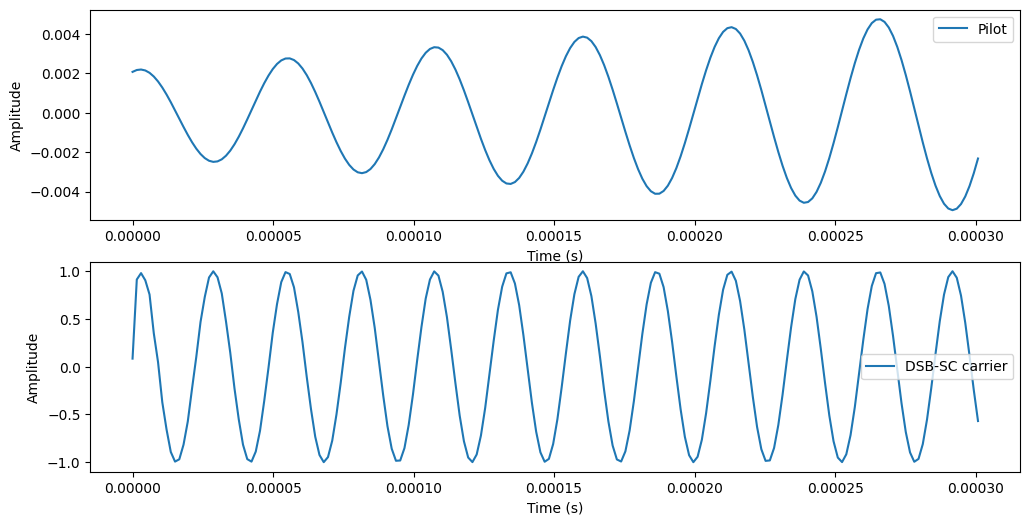

In [74]:

plt.figure(figsize=(12,6))
plt.subplot(2,1,1)
plt.plot(mRx_t[:200], pilot_tone[0:200], label='Pilot')
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()

plt.subplot(2,1,2)
plt.plot(mRx_t[:200], carrier_38[0:200], label='DSB-SC carrier')
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()

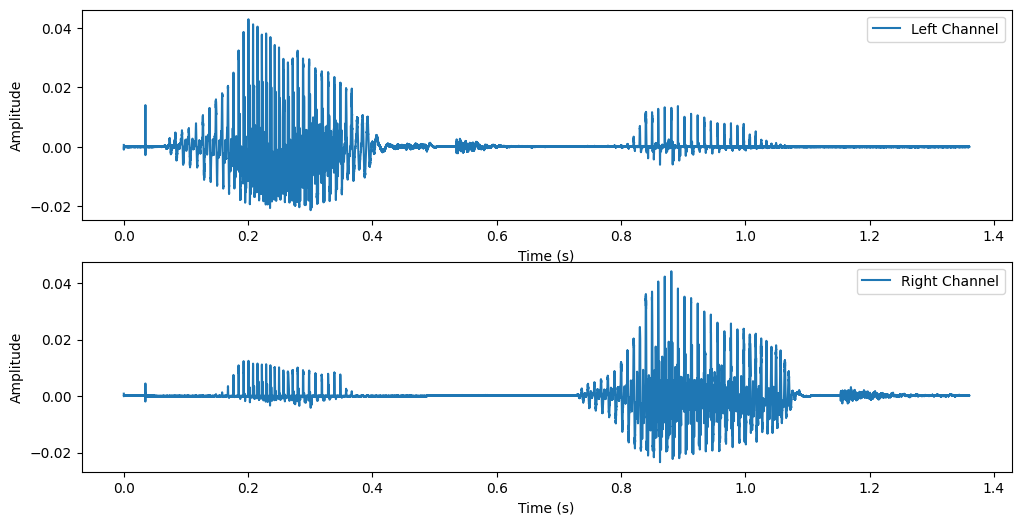

In [75]:
ds_t=np.arange(len(L_channel_ds))/fs_audio

plt.figure(figsize=(12,6))
plt.subplot(2,1,1)
plt.plot(ds_t,L_channel_ds , label='Left Channel')
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()

plt.subplot(2,1,2)
plt.plot(ds_t, R_channel_ds , label='Right Channel')
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()


In [76]:
from scipy.io.wavfile import write
stereo_demod = np.column_stack((L_channel_ds, R_channel_ds))
stereo_demod = np.int16(stereo_demod / np.max(np.abs(stereo_demod)) * 32767)
write("recovered_stereo.wav", int(fs_audio), stereo_demod)

End of the non-recieving section

In [116]:
# Define sampling rates
M = 15  # Upsampling factor
fs_audio = 44100  # Audio sampling rate (Hz)
fs = M * fs_audio  # PlutoSDR sampling rate (Hz)

# Set SDR parameters
sdr_carrier_freq = 107.1e6  # Choose FM station (Hz)
sdr_rx_gain = 50.0  # Rx gain (Adjust based on signal strength)
N = 900000  # Close to maximum buffer size (~1.4 sec per buffer)


# Create PlutoSDR object
sdr = adi.Pluto("ip:192.168.2.1")

# Configure common settings
sdr.sample_rate = int(fs)
sdr.gain_control_mode_chan0 = 'manual'

# Configure Rx
sdr.rx_lo = int(sdr_carrier_freq)
sdr.rx_rf_bandwidth = int(fs)
sdr.rx_buffer_size = int(N)  # Buffer size for Rx samples
sdr.rx_hardwaregain_chan0 = sdr_rx_gain  # Adjust Rx gain (0 to 74.5 dB)

In [1]:
# Clear buffer before capturing data
for _ in range(3):
    sdr.rx()
  
# Capture multiple frames (about 5 sec of audio)
num_frames = 4
raw_data = []
for _ in range(num_frames):
    temp = sdr.rx()
    raw_data = np.concatenate([raw_data, temp])
  
raw_data = np.array(raw_data) * 2**-14  # Scale samples to (-1,1)

NameError: name 'sdr' is not defined

In [121]:
#recover message

# Apply 53 kHz LPF (choose appropriate filter from Part 1)
filtered_data = filtfilt(b_LPF_rf, a_LPF_rf, raw_data)

# Extract phase from the complex signal
phase = np.unwrap(np.angle(filtered_data))

# Compute the FM demodulated message signal
mRx = np.diff(phase) / (2*np.pi)

# Append a zero to match the original length
mRx = np.append(mRx, mRx[-1])

mRx_fft = np.fft.fft(mRx)
mRx_t = np.arange(len(mRx))/fs
mRx_freq = np.fft.fftfreq(len(mRx), d= 1/fs)

L_R_audio = filtfilt(b_LPF_audio, a_LPF_audio, mRx)
pilot_tone = filtfilt(b_narrow, a_narrow, mRx)
bandpass = filtfilt(b_BPF, a_BPF, mRx)

#get phase of hilbert and double
analytic = hilbert(np.real(pilot_tone))
pilot_phase = np.unwrap(np.angle(analytic))
carrier_38 = np.cos(2*pilot_phase)

#demodulate using DSB-SC

L_minus_R = 2 * bandpass * carrier_38
L_minus_R = filtfilt(b_LPF_audio, a_LPF_audio, L_minus_R)

L_channel = (L_R_audio + L_minus_R) / 2
R_channel = (L_R_audio - L_minus_R) / 2

fs_audio = 44100
L_channel_ds = resample_poly(L_channel, fs_audio, fs)
R_channel_ds = resample_poly(R_channel, fs_audio, fs)

In [122]:
from scipy.io.wavfile import write
stereo_demod = np.column_stack((L_channel_ds, R_channel_ds))
stereo_demod = np.int16(stereo_demod / np.max(np.abs(stereo_demod)) * 32767)
write("eric_stereo.wav", int(fs_audio), stereo_demod)

mono_audio = (L_channel_ds + R_channel_ds) / 2
mono_audio = np.int16(mono_audio / np.max(np.abs(mono_audio)) * 32767)
write("eric_mono.wav", int(fs_audio), mono_audio)
